# Homework for Clustering Module

The purpose of this exercise is to perform clustering on the dataset using K-Means, agglomerative clustering and DBSCAN, compare the results and identify the best clustering algorithm for the given data.

## Imports and functions

In [ ]:
%pip install plotly --upgrade

In [ ]:
import plotly
print(f"plotly.__version__: {plotly.__version__}")

plotly.__version__: 5.18.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score, adjusted_mutual_info_score, calinski_harabasz_score

In [ ]:
%pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS

In [ ]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.style.use('ggplot')

In [ ]:
def plot_silhoettes(model, n, X):
  """
  Silhouette plot for estimating the optimal number of clusters
  """
  # Create a subplot with 1 row and 2 columns
  fig, ax = plt.subplots(1,1)
  fig.set_size_inches(7, 5)
  ax.set_xlim([-0.1, 1])

  cluster_labels = model.fit_predict(X)
  silhouette_avg = silhouette_score(X, cluster_labels)
  print('For n =', n, 'the average silhouette score is', silhouette_avg)

  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10

  for i in range(n):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_values = sample_silhouette_values[cluster_labels == i]
      ith_cluster_values.sort()
      ith_cluster_size = ith_cluster_values.shape[0]
      y_upper = y_lower + ith_cluster_size

      color = cm.nipy_spectral(float(i)/n)
      ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax.set_xlabel("Silhouette coefficient")
  ax.set_ylabel("Cluster labels")

  # The vertical line for average silhouette score of all the values
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax.set_yticks([])  # Clear the yaxis labels / ticks
  ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


  plt.suptitle(("Silhouette analysis on sample data "
                    "with n = %d" % n),
                    fontsize=14, weight='bold')

plt.show()

In [ ]:
def plot_dendrogram(model, **kwargs):
  """
  Dengrogram to estimate the optimal number of clusters
  """
  # Create linkage matrix and then plot the dendrogram
  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

  # Plot the corresponding dendrogram
  plt.title('Hierarchical Clustering Dendrogram')
  dendrogram(linkage_matrix, **kwargs)
  plt.xlabel("Number of points in node (or index of point if no parenthesis).")

## Loading the dataset

In [ ]:
df = read_drive_dataset(*HOMEWORK_DATASETS["quake"])
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


In [ ]:
df.duplicated().sum()

1

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

The dataset contains information about eqarthquakes, characterized by four numeric features - focal depth, latitude, longitude and magnitude on a Richter scale. Out of 2178 objects, there was only one duplicate, which we successfully dropped.

## EDA

In [ ]:
df.describe()

,Focal depth,Latitude,Longitude,Richter
count,2177.000000,2177.000000,2177.000000,2177.000000
mean,74.394120,7.942747,54.903785,5.977216
std,116.483644,30.539383,118.901774,0.189463
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.440000,-67.790000,5.800000
50%,39.000000,0.200000,122.110000,5.900000
75%,68.000000,36.480000,146.870000,6.100000
max,656.000000,78.150000,180.000000,6.900000


In [ ]:
fig = px.imshow(df.corr())
fig.update_layout(title='Feature Correlation Matrix')
fig.show()

We see that the features are very weakly correlated with each other, which is a good thing for our clusterization, as the distances between objects are affected by strong correlation.

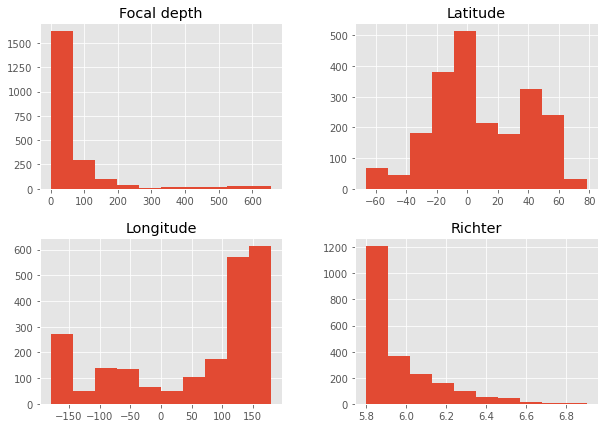

In [ ]:
df.hist()
plt.show()

None of the features are normally distributed - focal depth and Richter magnitude seem to have an exponential distribution, the former has a heavy tail with a small second peak around 600 m. Latitude and longitude can hardly be expected to be normally distributed, as they are confined to seismically active zones in the Earth crust.

In [ ]:
fig = px.scatter_3d(df, x = 'Focal depth', y = 'Latitude', z = 'Longitude', color = 'Richter')
fig.update_layout(title='Geographical Coordinates vs Depth vs Mangnitude of the Earthquakes')
fig.show()

The plot verifies the data obtained from feature distribution - longitude and latitude are distributed "naturally" (according to natural seismic activity of the Earth crust); as for depth, most of the earthquakes occur relatively close to Earth surface, though some areas are characterized by earthquakes with great focal depth. Richter magnitude does not seem to be strongly correlated with either focal depth or geographic location. The majority of earthquakes seem to have magnitude < 6.0. For better understanding let us visualize the data on the world map.

In [ ]:
fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', size='Focal depth',  color = 'Richter', width=1500, height=700)
fig.update_layout(title='Earthquake Map by Depth and Magnitude')
fig.show()

From the map we can infer that:
*   Earthquakes with great focal depth are usually confined to specific seismic zones (Pacific coast of South America, New Zealand, Indonesian archipelago, Russian Far East and Japan);
*   The strongest earthquakes usually originate relatively close to the surface (focal depth < 100-150 m).






## K-Means Clustering

In [ ]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(df)

As the features are not normally distributed, let us use MinMaxScaler to prepare them for clusterization.

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=101, n_init=10)
kmeans_clusters = kmeans.fit_predict(X_scaled)
df['kmeans_clusters'] = kmeans_clusters

In [ ]:
fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=kmeans_clusters,  width=1500, height=700)
fig.update_layout(title="KMeans clusterization (15 clusters)")
fig.show()

Clusters obtained by K-Means algorithm are mostly based on geographical coordinates, with extreme values of focal depth and Richter magnitude separated into individual clusters. Overall, the division is easily interpretable (e.g. cluster 3 - relatively weak eathquakes in North America, cluster 5 - relatively weak earthquakes in South America, etc.). The table below demonstrates how clusters 6, 13 and 14 are more focused on Richter magnitude, 4 and 9 - on depth and all the remaining ones - on geographical coordinates.

In [ ]:
df.groupby('kmeans_clusters')[['Focal depth', 'Richter']].mean()

,Focal depth,Richter
kmeans_clusters,,
0,49.644628,5.878512
1,53.421769,5.900000
2,44.011905,5.876190
3,28.536000,5.972000
4,492.857143,5.984416
5,49.868613,5.907299
6,46.300000,6.512000
7,62.473118,6.041398
8,57.204545,5.933333


### Estimation of the optimal number of clusters

To estimate the optimal number of clusters, let us use silhouette plots and the elbow method.

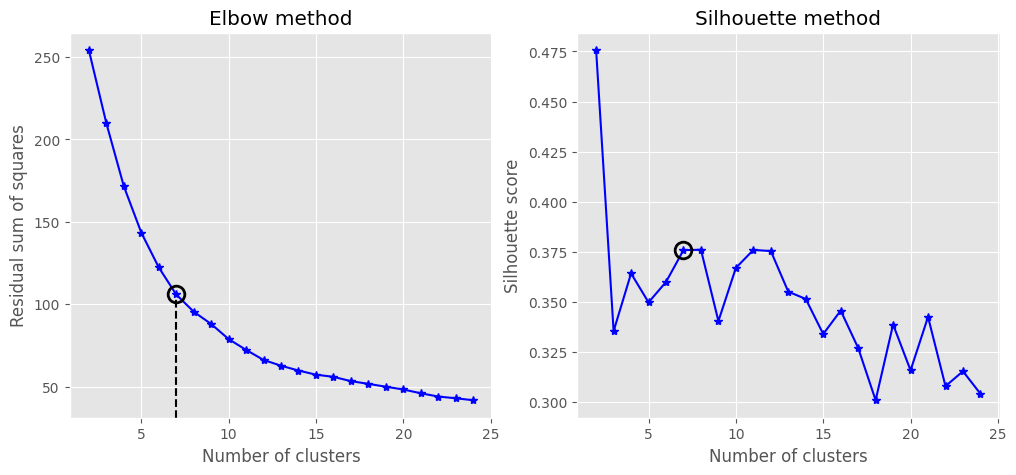

In [ ]:
inertias = []
ss = []
n_clust_grid = [i for i in range(2, 25)]
for n_clusters in n_clust_grid:
    kmeans = KMeans(n_clusters=n_clusters, random_state=101, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    avg_ss = silhouette_score(X_scaled, cluster_labels)
    ss.append(avg_ss)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
ax1.plot(n_clust_grid, inertias, marker="*", color='blue')
ax1.axvline(x=7, ymax=0.31, color='black', linestyle='--')
ax1.plot(n_clust_grid[5], inertias[5], marker='o', markersize=12,
markeredgewidth=2, markeredgecolor='black', markerfacecolor='None')
ax1.set_title('Elbow method')
ax1.set_ylabel('Residual sum of squares')
ax1.set_xlabel('Number of clusters')

ax2.plot(n_clust_grid, ss, marker="*", color='blue')
ax2.plot(n_clust_grid[5], ss[5], marker='o', markersize=12,
markeredgewidth=2, markeredgecolor='black', markerfacecolor='None')
ax2.set_title('Silhouette method')
ax2.set_ylabel('Silhouette score')
ax2.set_xlabel('Number of clusters')

plt.show()

According to the plot, the silhouette coefficient reaches its highest values at 7, 8 and 12 clusters. Let us choose 7 clusters for further analysis.

For n = 2 the average silhouette score is 0.4755991741461311
For n = 3 the average silhouette score is 0.3354989220889438
For n = 4 the average silhouette score is 0.36428070664153667
For n = 5 the average silhouette score is 0.3498296736675883
For n = 6 the average silhouette score is 0.3600100392749406
For n = 7 the average silhouette score is 0.3759061504929466
For n = 8 the average silhouette score is 0.3760669453509276


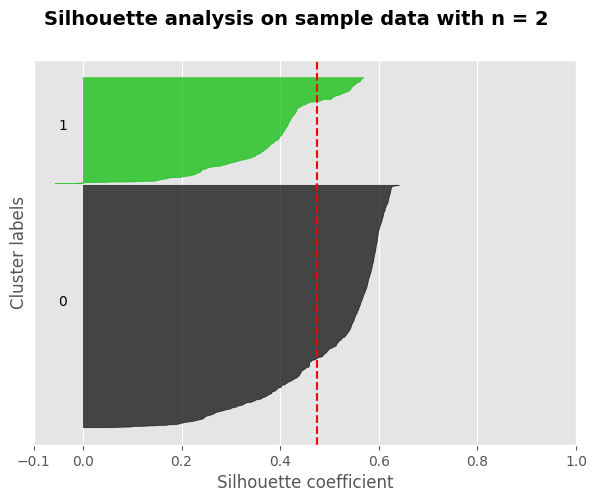

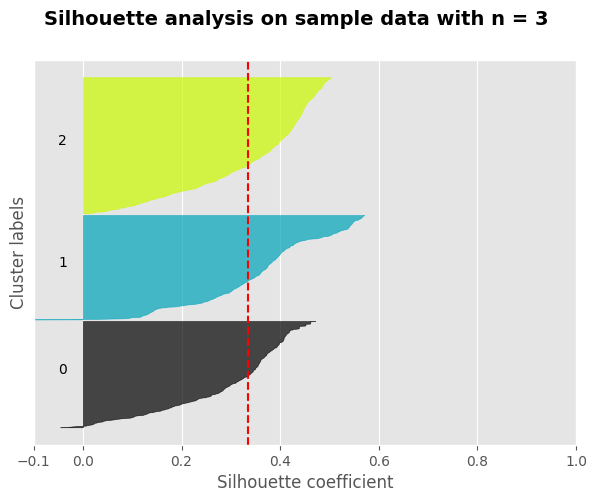

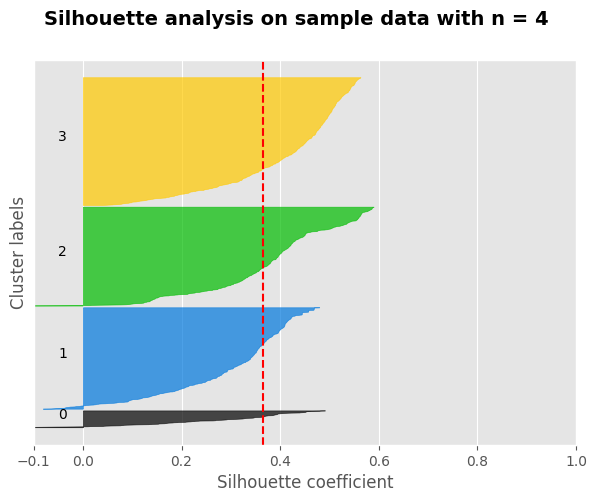

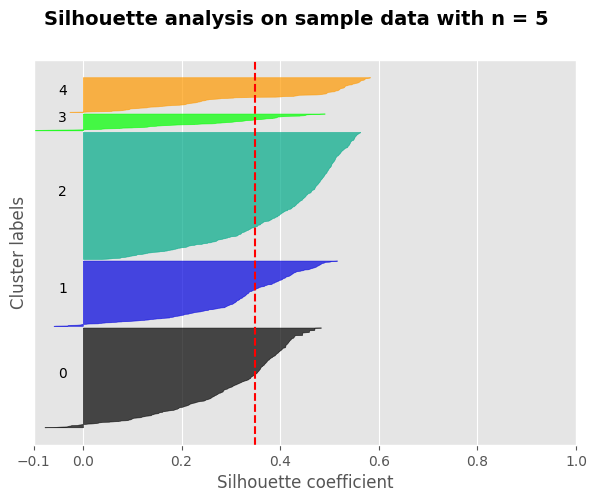

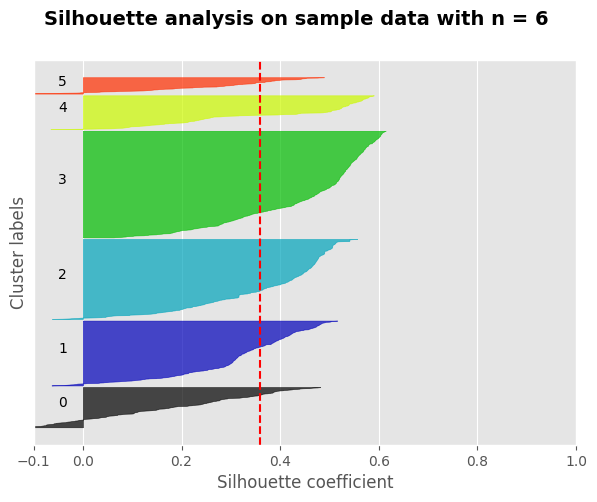

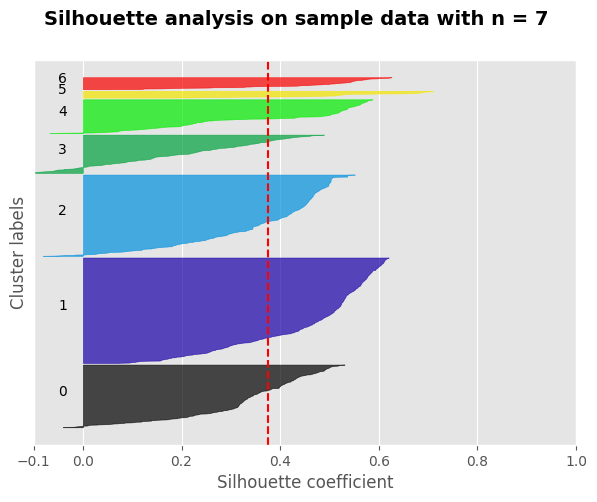

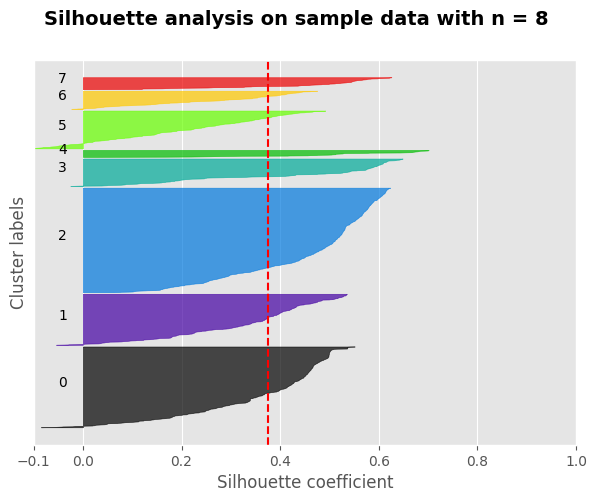

In [ ]:
for i in range(2, 9):
  kmeans = KMeans(n_clusters=i, random_state=101, n_init=10)
  plot_silhoettes(kmeans, i, X_scaled)

More detailed analysis of silhouette plots confirms that 7 is a good option. All the clusters have silhouette coefficients higher than average, and although the clusters are not exactly uniform, all of them are significant (contain > 40 objects).

A visualization of KMeans clusterization with 7 clusters is presented below. Once again, the clusters are easily interpretable in terms of geographic position, the most seismically active zones (South America, New Zealand, Indonesia, Far East) involve several clusters (by depth and by magnitude).

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=101, n_init=10)
kmeans_clusters = kmeans.fit_predict(X_scaled)
df['kmeans_clusters'] = kmeans_clusters

fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=kmeans_clusters,  width=1500, height=700)
fig.update_layout(title='KMeans clustering (7 clusters)')
fig.show()

Almost the same results are achieved by using minibatch kmeans:

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=7, random_state=101, n_init=10, batch_size=400)
kmeans_clusters = kmeans.fit_predict(X_scaled)
df['minibatch_kmeans_clusters'] = kmeans_clusters

fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=kmeans_clusters,  width=1500, height=700)
fig.update_layout(title='Minibatch KMeans clustering (7 clusters)')
fig.show()

## Agglomerative Clustering

In [ ]:
for affinity in ['euclidean', 'l2', 'l1', 'manhattan', 'cosine']:
  agglomerative = AgglomerativeClustering(n_clusters=7, metric=affinity, linkage='complete')
  cluster_labels_agg = agglomerative.fit_predict(X_scaled)
  print(affinity, silhouette_score(X_scaled, cluster_labels_agg))

euclidean 0.3578580967517637
l2 0.3578580967517637
l1 0.27310409673305464
manhattan 0.27310409673305464
cosine 0.2337978091751598


For the purposes of comparison let us train an agglomerative clustering model with the same number of clusters (n=7). The parameter that needs to be tuned is affinity. A short search demonstrates that the highest silhouette score is achieved with euclidean distance. We use complete linkage, as average linkage results in separation of too small clusters (<10 objects) and signle linkage leads to negative solhouette scores. Let us use obtained parameters to visualize clustering results.

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='complete')
agg_clusters = agglomerative.fit_predict(X_scaled)
df['agg_clusters'] = agg_clusters

fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=agg_clusters,  width=1500, height=700)
fig.update_layout(title='Agglomerative clustering (7 clusters)')
fig.show()

Visually the results seem close to those obtained by KMeans clustering, as they are still confined to more or less the same geographical areas. However, the silhouette score of KMeans is superior to that of agglomerative clustering.

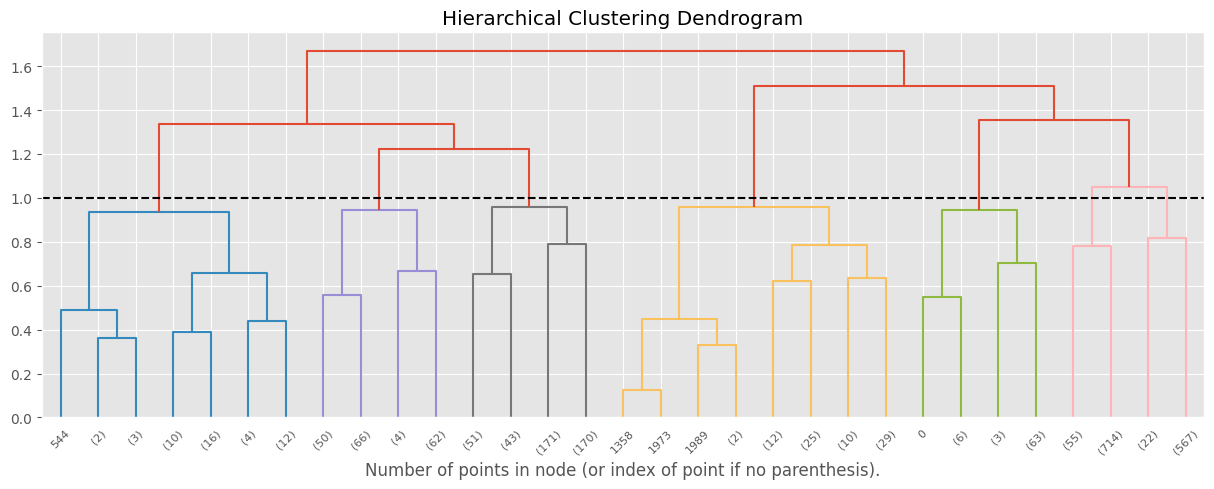

In [ ]:
agglomerative = AgglomerativeClustering(metric = 'euclidean', linkage='complete', distance_threshold=0, n_clusters=None)
agglomerative.fit(X_scaled)

plt.figure(figsize=(15,5))
plot_dendrogram(agglomerative, truncate_mode='level', p=4)
plt.axhline(c='black',linestyle='--', y=1)

plt.show()

The dendrogram itself cannot be considered a justified method for assessing the optimal number of clusters, but it helps to visualize similarity between clusters and their size. Given the structure of the data, it will be quite hard to divide them into uniform clusters, regardless of their number.

For n = 2 the average silhouette score is 0.4718459645204733
For n = 3 the average silhouette score is 0.45604912563105066
For n = 4 the average silhouette score is 0.3797919082226342
For n = 5 the average silhouette score is 0.38999054681822587
For n = 6 the average silhouette score is 0.37492550882884684
For n = 7 the average silhouette score is 0.3578580967517637
For n = 8 the average silhouette score is 0.3526953581896502


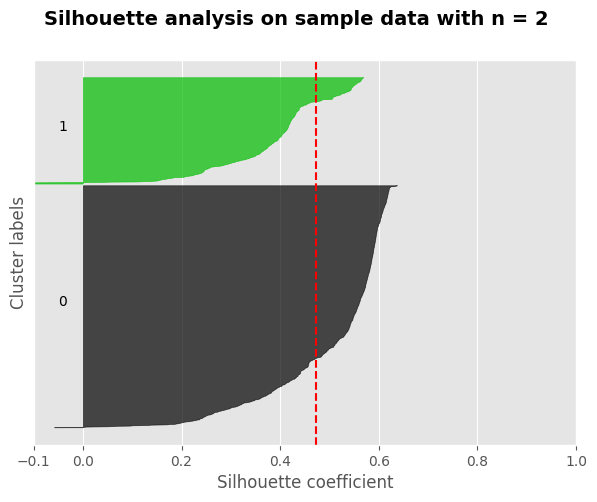

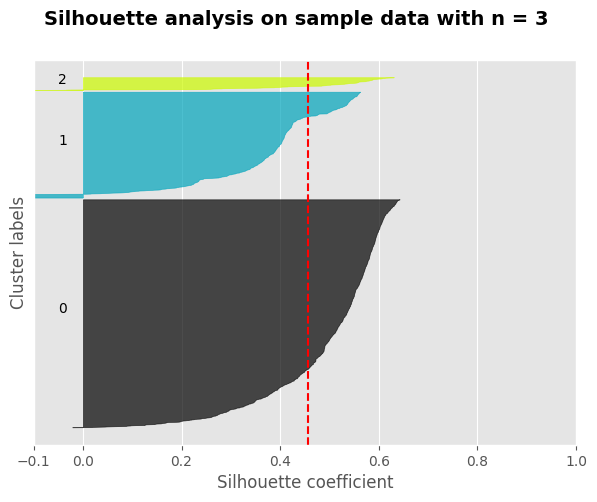

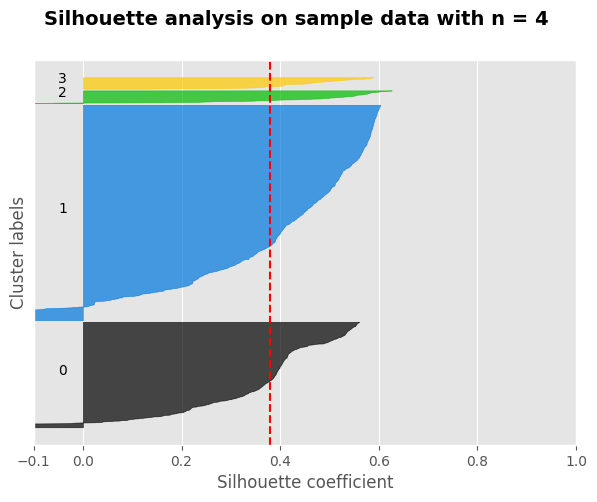

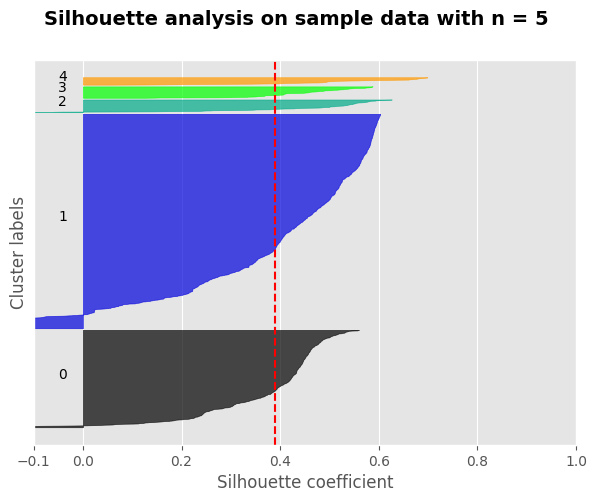

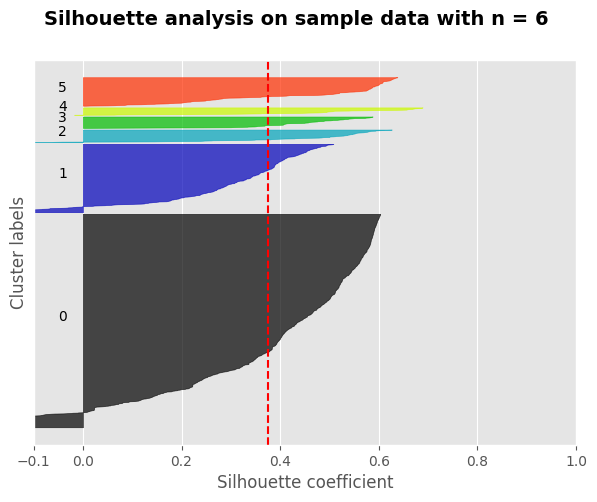

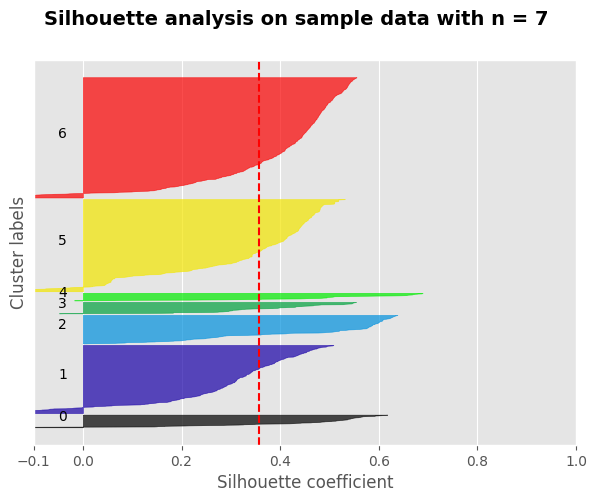

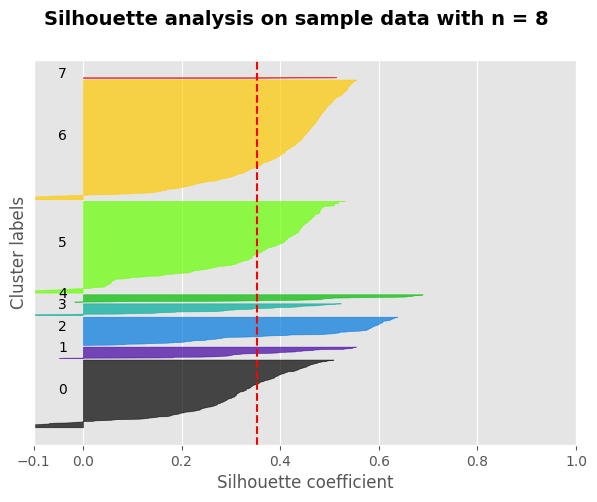

In [ ]:
for i in range(2, 9):
  agglomerative = AgglomerativeClustering(n_clusters=i, metric='euclidean', linkage='complete')
  plot_silhoettes(agglomerative, i, X_scaled)

In [ ]:
df.groupby('agg_clusters')['Focal depth'].count()

agg_clusters
0     81
1    435
2    182
3     73
4     48
5    589
6    769
Name: Focal depth, dtype: int64

Judging by the plots, we can see the operation of agglomerative clustering algorithm - combining similar clusters into a single larger one. Obtained pictures clearly demonstrate the more clusters we have, the more uniform they are - if we have only 5 clusters, two of them are much larger than the rest. In case of 7 clusters, some of them are "dominant" too, but on the average their sizes get closer to each other.

The silhouette score has a different dynamics compared to KMeans. In the latter case it has several peaks, but generally it grows with an increase in the number of clusters from 3 to 7 and higher. In the agglomerative clustering the situation is the opposite, the score is at its highest around 2-3 clusters, than slightly increases again around 5 and then drops. Still, division into five clusters is suboptimal from the viewpoint of cluster size homogeneity, and we will continue to use n=7 to make two algorithms comparable.

## DBSCAN

In DBSCAN algorithm, parameters that need to be tuned are epsilon (maximum radius of the neighborhood) and min_samples (minimum number of points in the neighborhood). We are searching for a combination with seven clusters.

In [ ]:
res = []
for epsilon in np.linspace(0.1, 0.2, 11):
  for min_samples in np.linspace(5, 50, 10):
    dbscan = DBSCAN(eps=epsilon, min_samples=int(min_samples), metric='manhattan')
    dbscan_clusters = dbscan.fit_predict(X_scaled)
    if len(set(dbscan_clusters) - set([-1])) > 3 and silhouette_score(X_scaled, dbscan_clusters) > 0.25:
      ss_value = silhouette_score(X_scaled, dbscan_clusters)
      n_clusters = np.unique(dbscan_clusters).size-1
      n_outliers = dbscan_clusters[dbscan_clusters == -1].size
      row = [epsilon, min_samples, ss_value, n_clusters, n_outliers]
      res.append(row)

result = pd.DataFrame(res, columns=['eps', 'min_samples', 'ss_value', 'n_clusters', 'n_outliers'])
result.sort_values(by='ss_value', ascending=False).query('n_clusters == 7')

,eps,min_samples,ss_value,n_clusters,n_outliers
0,0.13,10.0,0.284265,7,466


Clearly, obtained clusterization is not the best one - the silhouette score is much lower than before, and the algorithm identified 466 objects (~20%) as outliers.

In [ ]:
dbscan = DBSCAN(eps=0.13, min_samples=10, metric='manhattan')
dbscan_clusters = dbscan.fit_predict(X_scaled)
df['dbscan_clusters'] = dbscan_clusters

fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=dbscan_clusters,  width=1500, height=700)
fig.update_layout(title='DBSCAN Clustering')
fig.show()

In [ ]:
df.groupby('dbscan_clusters')['Focal depth'].count()

dbscan_clusters
-1     466
 0    1258
 1      98
 2      40
 3     115
 4     178
 5      11
 6      11
Name: Focal depth, dtype: int64

For n = 7 the average silhouette score is 0.28426533024052564


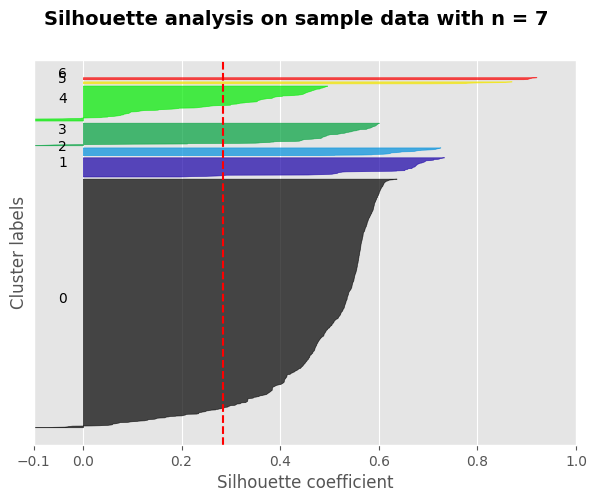

In [ ]:
plot_silhoettes(dbscan, 7, X_scaled)

Apart from a large number of outliers, the problem with this clusterization is a giant cluster 0 (> 1000 objects), whereas all the rest have relatively small sizes (clusters 5 and 6 contain only 11 objects each).

## Comparison of clustering algorithms

In order to compare our clustering algorithms, we can use labeled metrics (mutual information score, adjusted Rand score) and unlabeled ones (silhouette score, Calinski-Harabasz score).

In [ ]:
print('Adjusted MI score:')
for i in ['agg_clusters', 'dbscan_clusters']:
  print(i, adjusted_mutual_info_score(kmeans_clusters, df[i]))

Adjusted MI score:
agg_clusters 0.787244532604326
dbscan_clusters 0.44882924785910494


In [ ]:
print('Adjusted Rand score:')
for i in ['agg_clusters', 'dbscan_clusters']:
  print(i, adjusted_rand_score(kmeans_clusters, df[i]))

Adjusted Rand score:
agg_clusters 0.7756711658588159
dbscan_clusters 0.31003019132372633


In [ ]:
print('Silhouette score:')
for i in ['kmeans_clusters', 'minibatch_kmeans_clusters', 'agg_clusters', 'dbscan_clusters']:
  print(i, silhouette_score(X_scaled, df[i]))

Silhouette score:
kmeans_clusters 0.3759061504929466
minibatch_kmeans_clusters 0.37523400628789527
agg_clusters 0.3578580967517637
dbscan_clusters 0.28426533024052564


In [ ]:
print('Calinski-Harabasz score:')
for i in ['kmeans_clusters', 'minibatch_kmeans_clusters', 'agg_clusters', 'dbscan_clusters']:
  print(i, calinski_harabasz_score(X_scaled, df[i]))

Calinski-Harabasz score:
kmeans_clusters 1233.8648547075884
minibatch_kmeans_clusters 1231.9273244581234
agg_clusters 1094.217011824414
dbscan_clusters 317.7087106474377


All the metrics show that the best result is obtained by KMeans clustering. Agglomerative clustering has a close but slightly inferior result. Compared to these two algorithms, DBSCAN performed poorly on the dataset, its scores a significantly lower.

Overall, it can be observed how KMeans creates more or less uniform spherical clusters, taking into account all the features (geographical location, focal depth and magnitude). The resulting clusters are clearly confined to certian seismic zones of the Earth crust and are easily interpretable.

Agglomerative clustering yields similar but slighly less uniform results due to the specifics of its operation - smaller clusters get merged together to form larger agglomerated clusters, which creates a certian imbalance.

DBSCAN failed to yield any human-interpretable results and assigned the majority of objects into one giant cluster. No tuning of the parameters could change that. Probably this is due to the fact that DBSCAN can have problems with the data of varying density.  

Below is the visualization of the best clusterization, KMeans with 7 clusters.

In [ ]:
fig = px.scatter_geo(df, lon='Longitude', lat='Latitude', color=kmeans_clusters,  width=1500, height=700)
fig.update_layout(title='KMeans clustering (7 clusters)')
fig.show()

## Conclusions

In this task, we performed clustering of unlabeled data on earthquakes using three algorithms: KMeans, Agglomerative Clustering and DBSCAN. The dataset contained geographical coordinates, focal depth and Richter magnitude of more than 2000 eathquakes, and the assumption was that all of these features need to be taken into consideration in the process of clustering.

The baseline model was KMeans. By means of elbow method and analysis of silhouette score and plots, we estimated the optimal number of clusters to be 7. All the other clustering algorithms were tuned to the same number of clusters to make the results comparable to each other.

Agglomerative clustering yielded similar but slightly lower results than KMeans. Despite parameter tuning, DBSCAN did not perform well on the dataset and identified clusters were neither uniform nor interpretable.

All the results were compared using labeled metrics (adjusted MI score and adjusted Rand score with KMeans labels as ground truth) and unlabeled metrics (silhouette score and Calinski-Harabasz score). Unanimously, the best clusterization algorithm for this dataset was KMeans, which yielded uniform and easily interpretable clusters that took into consideration all features of the objects.